In [1]:
%load_ext autoreload
%autoreload 2
from scipy import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

import tensorflow as tf
tf.config.list_physical_devices('GPU')

try: 
    from dag_prf_utils.plot_functions import *
except:
    print('Install dag_prf_utils for useful plotting functions')
    print(f'!pip install git+https://github.com/mdaghlian/dag_prf_utils.git')
    

Could not find path for freeview, is freesurfer accessible from here?
Could not find FS_LICENSE
Uncomment line below and specify path to FS_LICENSE
Error importing pycortex... Not a problem unless you want to use pycortex stuff
SUBJECTS_DIR not found in os.environ
Adding empty string...


In [2]:
dm = io.loadmat('GazeCenterFS_vd.mat')['stim']

# braincoder convention is time by x by y
paradigm = np.rollaxis(dm, 2, 0)
aspect_ratio = paradigm.shape[2] / paradigm.shape[1]

x, y = np.meshgrid(np.linspace(-.75, .75, 3), np.linspace(-aspect_ratio *.75, aspect_ratio *.75, 3))

In [3]:
parameters = pd.DataFrame({'x':x.ravel(),
               'y':y.ravel(),
               'sd':.2,
               'amplitude':1,
               'baseline':0.0}).astype(np.float32)

y_grid, x_grid = np.meshgrid(np.linspace(-aspect_ratio, aspect_ratio, paradigm.shape[2]), 
                              np.linspace(-1., 1., paradigm.shape[1]))

grid_coordinates = np.stack((x_grid.ravel().astype(np.float32), y_grid.ravel().astype(np.float32)), 1)

y_grid, x_grid = np.meshgrid(np.linspace(-aspect_ratio, aspect_ratio, paradigm.shape[2]), 
                              np.linspace(-1., 1., paradigm.shape[1]))

grid_coordinates = np.stack((x_grid.ravel().astype(np.float32), y_grid.ravel().astype(np.float32)), 1)

In [4]:
from braincoder.models import GaussianPRF2DWithHRF
from braincoder.hrf import SPMHRFModel

In [5]:
model = GaussianPRF2DWithHRF(grid_coordinates, 
                      paradigm=paradigm,
                     parameters=parameters,
                      hrf_model=SPMHRFModel(tr=1.7))

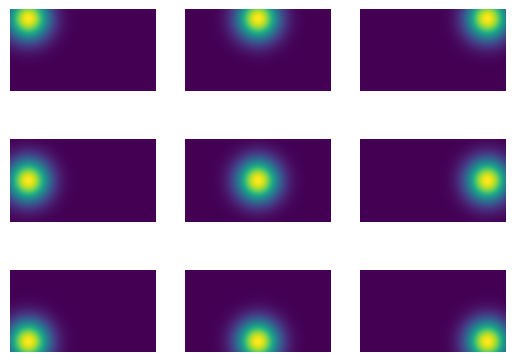

In [6]:
for i in np.arange(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(model.get_rf()[i].reshape((240, 135)).T)
    plt.axis("off")

## Predictions (no noise)

<Axes: xlabel='frame'>

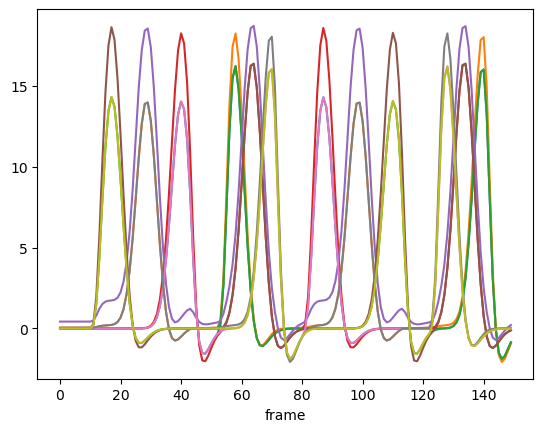

In [7]:
pred = model.predict()
pred.plot(legend=False)

## Noisy predictions

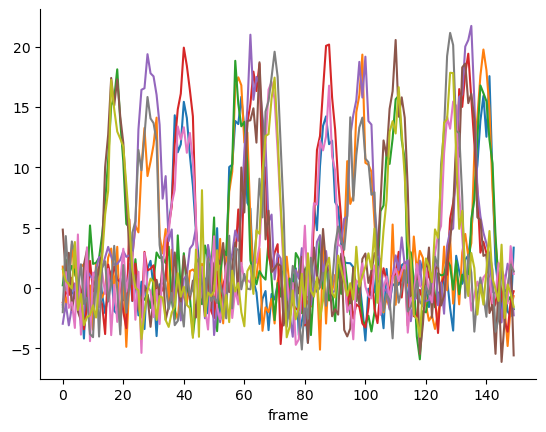

In [8]:
data = model.simulate(noise=2)
data.plot(legend=False)
sns.despine()

# Estimate parameters

In [9]:
from braincoder.optimize import ParameterFitter
from braincoder.bprf_mcmc import BPRF

/Users/marcusdaghlian/miniforge3/envs/braincoder/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
model = GaussianPRF2DWithHRF(grid_coordinates, 
                      paradigm=paradigm,
                     parameters=parameters,
                      hrf_model=SPMHRFModel(tr=1.7))
cfitter = ParameterFitter(model, data, paradigm)


grid_pars = cfitter.fit_grid(x=np.linspace(-1, 1, 20), 
                            y=np.linspace(-aspect_ratio, aspect_ratio, 20),
                            sd=np.linspace(0.01, 1., 10),
                            baseline=[0.0],
                            amplitude=[1.0],
                            use_correlation_cost=True)
ols_pars = cfitter.refine_baseline_and_amplitude(grid_pars)
refined_pars = cfitter.fit(init_pars=ols_pars)
n_vx = refined_pars.shape[0]

Working with chunk size of 82304
Using correlation cost!


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


Number of problematic voxels (mask): 0
Number of voxels remaining (mask): 9


Current R2: 0.87552/Best R2: 0.87552:  17%|█▋        | 170/1000 [00:01<00:09, 90.21it/s] 


In [11]:
n_vx

9

In [12]:
cfitter.get_rsq(refined_pars)

source
0    0.874566
1    0.847430
2    0.863055
3    0.923093
4    0.916943
5    0.868449
6    0.857840
7    0.871580
8    0.856749
Name: r2, dtype: float32

parameter         x         y        sd  baseline  amplitude
0         -0.739367 -0.433825  0.208952 -0.144163   1.000007


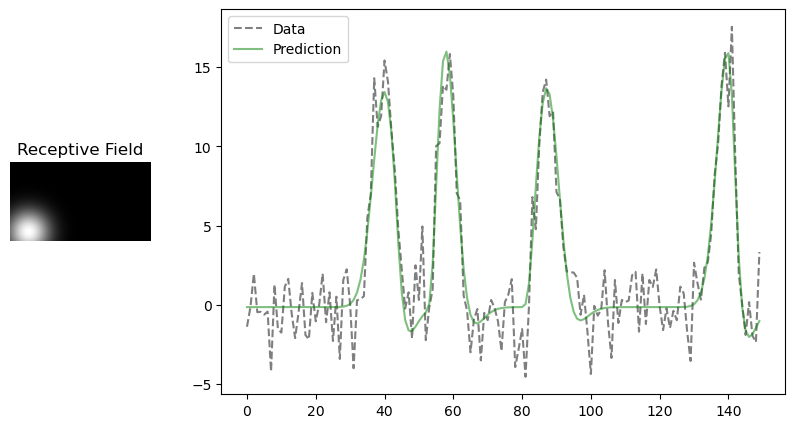

In [13]:
idx = 0
from braincoder.utils.visualize import quick_plot
quick_plot(
    model=model, 
    parameters=refined_pars.iloc[idx,:],
    data=data.iloc[:,idx]
)

# MCMC Gaussian

In [14]:
bounds = {
    'x' : [-1, 1],
    'y' : [-1, 1],
    'sd' : [0, 5],
    'baseline' : [-1,1],
    'amplitude' : [0, 5], 
}

n_vx = parameters.shape[0]
init_pars = pd.DataFrame({    
    'x' : np.zeros(n_vx),
    'y' : np.zeros(n_vx),
    'sd' : np.ones(n_vx),
    'amplitude' : np.ones(n_vx),
    'baseline' : np.zeros(n_vx),
})

# No priors, no transformations on the parameters...
bfitter = BPRF(model=model, data=data, )
bfitter.prep_for_fitting()


In [27]:
num_results = 5
tf.random.set_seed(1)
# No priors, no transformations on the parameters...
bfitter = BPRF(model=model, data=data, )
bfitter.prep_for_fitting()
bfitter.fit(
    # idx=idx,
    init_pars=init_pars,
    num_results=num_results,
)


Lets run some checks with everything...
Using tape.gradient to check gradients w/respect to each parameter
Gradient for parameter 0: [-848.10815]
Gradient for parameter 1: [-743.3224]
Gradient for parameter 2: [3464.3806]
Gradient for parameter 3: [-477.8774]
Gradient for parameter 4: [-4791.4917]
idx=range(0, 9); initial_ll=[-3361.6064]
Calling "sample_hmc" from braincoder.utils.mcmc
Lets run some checks with everything...
Using tape.gradient to check gradients w/respect to each parameter
Gradient for parameter 0: [38.653687]
Gradient for parameter 1: [-817.8363]
Gradient for parameter 2: [2154.961]
Gradient for parameter 3: [-390.50443]
Gradient for parameter 4: [-3769.7288]
idx=range(0, 9); initial_ll=[-2869.9702]
Calling "sample_hmc" from braincoder.utils.mcmc
Lets run some checks with everything...
Using tape.gradient to check gradients w/respect to each parameter
Gradient for parameter 0: [833.65094]
Gradient for parameter 1: [-698.7903]
Gradient for parameter 2: [3195.4326]
Grad

In [40]:
num_results = 5
tf.random.set_seed(1)
# No priors, no transformations on the parameters...
bfitter = BPRF(model=model, data=data, )
bfitter.prep_for_fitting()
bfitter.fit_all(
    # idx=idx,
    init_pars=init_pars,
    num_results=num_results,
)


Lets run some checks with everything...


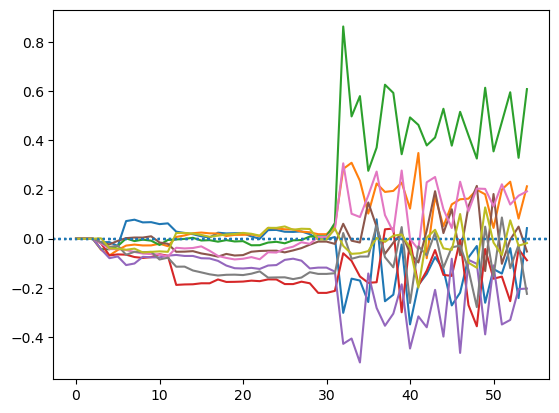

In [52]:
p = 'baseline'
plt.figure()
for i in range(bfitter.n_voxels):
    plt.plot(
        bfitter.mcmc_sampler[i][p]
    )
    plt.axhline(parameters[p][i], linestyle=':')

In [22]:
bfitter.data.to_numpy()

array([[-1.3839413 ,  1.7590489 ,  0.21073224, ..., -1.575008  ,
        -2.0199225 ,  1.523037  ],
       [-0.14793836, -1.5784986 ,  2.354504  , ...,  1.3121779 ,
         4.292131  ,  0.6032173 ],
       [ 1.9598838 ,  0.0731361 ,  1.0436891 , ..., -1.6602316 ,
         0.5255116 ,  0.2646733 ],
       ...,
       [-1.9523451 , -4.824658  , -1.1271687 , ..., -1.2899686 ,
        -0.10636491,  0.28714922],
       [-2.3577194 , -1.6037797 , -0.7127879 , ...,  3.4590497 ,
         1.926025  , -0.45320874],
       [ 3.3314822 , -0.6895453 , -1.767698  , ...,  1.1513717 ,
         1.3614858 , -1.5627748 ]], dtype=float32)

/var/folders/01/hhsk37310zsgzgg1nhgs6rfm0000gn/T/ipykernel_97041/2423663613.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


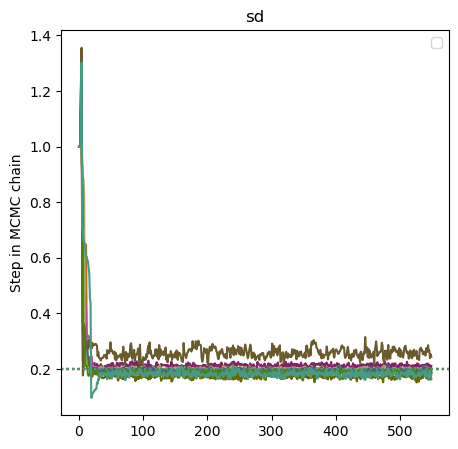

In [16]:
# Lets see are we getting closer?
fig,ax = plt.subplots(1,1,figsize=(5,5))
p = 'sd'
ax.set_title(p)
ax.set_ylabel('Step in MCMC chain')
for i in range(9):
    color = np.random.rand(3,)
    ax.plot(
        bfitter.mcmc_sampler[i][p],
        color=color,        
        )
    ax.axhline(
        parameters[p][i], color=color, linestyle=':'
    )

plt.legend()

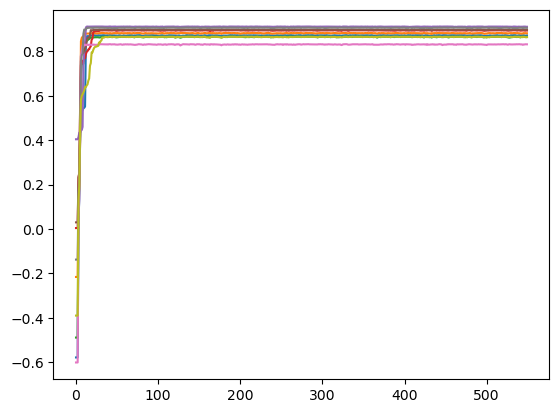

In [17]:
for idx in range(9):
    rsq = bfitter.get_rsq_for_idx(
        idx=idx, parameters=bfitter.mcmc_sampler[idx],
    )
    plt.plot(rsq) # should be improving with steps (up to a point)

In [ ]:
idx = 0
burn_in = 100
sns_plot = sns.pairplot(
    bfitter.mcmc_sampler[idx].iloc[burn_in:,:],
    diag_kind='kde', corner=True, 
)
# sns_plot.map_lower(sns.kdeplot, levels=4, color=0.2)
from dag_prf_utils.plot_functions import *

# Add ground truth lines to the plot 
edit_pair_plot(
    sns_plot.axes, 
    lines_dict=parameters.iloc[idx,:].to_dict(), 
    color='g', linestyle=':', lw=2, alpha=.5,
    label='Truth',
    lim_dict=bounds,
)
dag_update_fig_fontsize(plt.gcf(), 20, include=['xlabel', 'ylabel'])
dag_update_fig_fontsize(plt.gcf(), 15, include=['xticks', 'yticks'])
plt.gcf().tight_layout()

In [ ]:
# Again but more noise?
data = model.simulate(noise=80)
plt.plot(data.iloc[:,0])
sns.despine()
idx = 0
num_results = 500
tf.random.set_seed(1)
# No priors, no transformations on the parameters...
bfitter = BPRF(model=model, data=data, )
bfitter.prep_for_fitting()
bfitter.fit(
    idx=idx,
    init_pars=init_pars,
    num_results=num_results,
)
rsq = bfitter.get_rsq_for_idx(
    idx=idx, parameters=bfitter.mcmc_sampler[idx],
)
plt.plot(rsq) # should be improving with steps (up to a point)

In [ ]:
idx = 0
burn_in = 0
sns_plot = sns.pairplot(
    bfitter.mcmc_sampler[idx].iloc[burn_in:,:],
    diag_kind='kde', corner=True, 
)
# sns_plot.map_lower(sns.kdeplot, levels=4, color=0.2)
from dag_prf_utils.plot_functions import *

# Add ground truth lines to the plot 
edit_pair_plot(
    sns_plot.axes, 
    lines_dict=parameters.iloc[idx,:].to_dict(), 
    color='g', linestyle=':', lw=2, alpha=.5,
    label='Truth',
    # lim_dict=bounds,
)
dag_update_fig_fontsize(plt.gcf(), 20, include=['xlabel', 'ylabel'])
dag_update_fig_fontsize(plt.gcf(), 15, include=['xticks', 'yticks'])
plt.gcf().tight_layout()

# Mexican hat model

In [27]:
from braincoder.models import DifferenceOfGaussiansPRF2DWithHRF

In [ ]:
parameters_dog = pd.DataFrame({'x':x.ravel(),
               'y':y.ravel(),
               'sd':.2,
               'amplitude':0.3,
               'baseline':0.0,
               'srf_amplitude':.4, 
               'srf_size':2}).astype(np.float32)
model_dog = DifferenceOfGaussiansPRF2DWithHRF(grid_coordinates, paradigm, parameters=parameters_dog,
                                             hrf_model=SPMHRFModel(tr=1.8))
pred_dog = model_dog.predict()
pred_dog.plot()

In [ ]:
data_dog = model_dog.simulate(noise=.1)
data_dog.plot(legend=False)
sns.despine()

In [33]:
fitter_dog = ParameterFitter(model_dog, data_dog, paradigm)

In [34]:
init_pars_dog = refined_pars.copy()
init_pars_dog['srf_amplitude'] = 0.1
init_pars_dog['srf_size'] = 2.

In [ ]:
est_pars_dog = fitter_dog.fit(
    init_pars=init_pars_dog, learning_rate=0.001,
    max_n_iterations=5000,
    )

In [ ]:
idx = 0
est_pred = model_dog.predict(parameters=est_pars_dog)
est_pred[idx].plot()
data_dog[idx].plot()
print(est_pars_dog.iloc[idx,:])
print(parameters_dog.iloc[idx,:])


# MCMC - DOG

In [69]:
bounds_dog = {
    'x' : [-5, 5],
    'y' : [-5, 5],
    'sd' : [0, 10],
    'baseline' : [-2,2],
    'amplitude' : [0,100], 
    'srf_amplitude': [0, 10],
    'srf_size' : [1, 10],

}

n_vx = parameters_dog.shape[0]
init_pars_dog = pd.DataFrame({    
    'x' : np.zeros(n_vx),
    'y' : np.zeros(n_vx),
    'sd' : np.zeros(n_vx)+1,
    'baseline' : np.zeros(n_vx),
    'amplitude' : np.zeros(n_vx) + 1,
    'srf_amplitude' : np.zeros(n_vx) + .5,
    'srf_size' : np.zeros(n_vx) + 2,

})
bfitter_dog = BPRF(model=model_dog, data=data_dog, )
# for p in ['sd', 'amplitude', 'srf_amplitude', 'srf_size']:
#     bfitter_dog.add_bijector(
#         pid=p, bijector_type='sigmoid', vmin=bounds_dog[p][0], vmax=bounds_dog[p][1]
        
#     )
bfitter_dog.add_priors_from_bounds(bounds_dog, ) #prior_type='latent_uniform')
bfitter_dog.prep_for_fitting()

In [ ]:
bfitter_dog.model.parameter_labels


In [ ]:
bfitter_dog.fit(
    idx=[0,], #2,3], 
    init_pars=init_pars_dog,
    num_results=500,         
)

In [ ]:
idx = 0
burn_in = 0

rsq = bfitter_dog.get_rsq_for_idx(
    idx=idx, parameters=bfitter_dog.mcmc_sampler[idx],
)
plt.plot(rsq)
plt.figure()
rsq_cols = dag_get_col_vals(
    rsq, cmap='RdBu_r', vmin=-1, vmax=1,
    )

sns_plot = sns.pairplot(
    bfitter_dog.mcmc_sampler[idx].iloc[burn_in:,:],
    plot_kws={'color':rsq_cols[burn_in:,:]},
    # corner=True, 
    diag_kind='kde'
)
sns_plot.map_lower(sns.kdeplot, levels=4, color=0.2)
# sns_plot.
edit_pair_plot(
    sns_plot.axes, lines_dict=parameters_dog.iloc[idx,:].to_dict(), color='g', linestyle=':'
)
# edit_pair_plot(
#     sns_plot.axes, init_pars.iloc[idx,:].to_dict(), color='c', linestyle=':', lw=4,
# )
# edit_pair_plot(
#     sns_plot.axes, refined_pars.iloc[idx,:].to_dict(), color='r', linestyle=':', lw=4,
# )
plt.show()

In [ ]:
plt.plot(
    bfitter_dog.mcmc_sampler[idx].x
)

In [ ]:
bfitter_dog.mcmc_sampler[idx].shape

In [ ]:
bfitter_dog.mcmc_sampler[0].x